In [45]:
# Autoreload extension for Jupyter notebooks
%load_ext autoreload
%autoreload 2

# Manual reload

# Magic commands for inline plotting and high-res figures
%matplotlib inline
%config InlineBackend.figure_format ='retina'

# Standard library imports
import os
import sys

# Third-party library imports
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from jupyterthemes import jtplot

# Custom modules (if needed)
# module_path = os.path.join(os.path.expanduser('~'), 'CustomModules')
# sys.path.append(module_path)
# from telegram_notify import notify
# from plotting_tools import error_band_plot, get_ax_data_range

# Add the parent directory to sys.path (if needed)
from pathlib import Path

sys.path.append(str(Path(os.getcwd()).parent))

# Other modules (if needed)

# Pandas and plotting configurations
pd.set_option("display.max_rows", 1000)
idx = pd.IndexSlice

jtplot.style(context="paper", theme="grade3", grid=False, ticks=True)
DFT_FIG_WIDTH_WIDE = 11
DFT_FIG_WIDTH = 5.3
COLORS = plt.get_cmap("tab10")
# Choose in ['Pastel1', 'Pastel2', 'Paired', 'Accent', 'Dark2', 'Set1', 'Set2', 'Set3',
# 'tab10', 'tab20', 'tab20b', 'tab20c']

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Collect data

## Cult+growing data

In [46]:
data_dir = "../simulations/cult_growing/data"

In [47]:
df_cult_succ_path = os.path.join(data_dir, "df_cult_succ.csv")
df_cult_succ = pd.read_csv(df_cult_succ_path)
df_cult_succ.set_index(["p", "dcult", "dm"], inplace=True)
df_cult_succ = df_cult_succ[df_cult_succ["shots"] > 3e7]
df_cult_succ

shots  num_cult_succ
p      dcult dm                           
0.0005 3     5    100000000       80205838
             9    100000000       80203152
             13   100000000       80201447
       5     7   1000000000      346778365
             11  1000000000      346824964
             15  1000000000      346786568
0.0010 3     5    100000000       64355652
             9    100000000       64346977
             13   100000000       64352580
       5     7   1000000000      120445789
             11  1000000000      120423840
             15  1000000000      120434636

In [48]:
# Create a dictionary to store the logical errors dataframes
dfs_logical_errors = {}

# Iterate through each index in df_cult_succ
for index in df_cult_succ.index:
    p, dcult, dm = index

    # Construct the file path
    file_path = f"{data_dir}/df_logical_errors_p{p}_dcult{dcult}_dm{dm}.csv"

    try:
        # Load the CSV file
        df = pd.read_csv(file_path)

        # Set column "c" as index
        df.set_index("c", inplace=True)

        # Remove rows where both num_fails and num_accepted are 0
        df = df[(df["num_fails"] != 0) | (df["num_accepted"] != 0)]

        # Add the dataframe to the dictionary with (p, dcult, dm) as key
        dfs_logical_errors[(p, dcult, dm)] = df

    except FileNotFoundError:
        print(f"File not found: {file_path}")
    except Exception as e:
        print(f"Error loading {file_path}: {str(e)}")

# Print the number of loaded dataframes
print(f"Loaded {len(dfs_logical_errors)} logical errors dataframes")

Loaded 12 logical errors dataframes


In [49]:
dfs_logical_errors[(1e-3, 3, 5)]

,num_fails,num_accepted
c,,
0.00,341531,64355652
0.01,340076,64352214
0.02,339196,64350371
0.03,337267,64347110
0.04,335824,64344277
...,...,...
16.14,0,2
16.15,0,2
16.16,0,2


In [50]:
from src.color_code_stim.utils import get_pfail

psucc_cult, delta_psucc_cult = get_pfail(
    df_cult_succ["shots"], df_cult_succ["num_cult_succ"]
)
df_cult_succ["psucc_cult"] = psucc_cult
df_cult_succ["delta_psucc_cult"] = delta_psucc_cult
df_cult_succ

shots  num_cult_succ  psucc_cult  delta_psucc_cult
p      dcult dm                                                         
0.0005 3     5    100000000       80205838    0.802058          0.000103
             9    100000000       80203152    0.802031          0.000103
             13   100000000       80201447    0.802014          0.000103
       5     7   1000000000      346778365    0.346778          0.000039
             11  1000000000      346824964    0.346825          0.000039
             15  1000000000      346786568    0.346787          0.000039
0.0010 3     5    100000000       64355652    0.643557          0.000123
             9    100000000       64346977    0.643470          0.000123
             13   100000000       64352580    0.643526          0.000123
       5     7   1000000000      120445789    0.120446          0.000027
             11  1000000000      120423840    0.120424          0.000027
             15  1000000000      120434636    0.120435          0.000027

In [51]:
from src.color_code_stim.utils import get_pfail

dfs = {}
for key, df in dfs_logical_errors.items():
    df = df.copy()

    plogs, delta_plogs = get_pfail(df["num_accepted"], df["num_fails"])
    df["plog"] = 2 * plogs  # Assumption in the cultivation paper
    df["delta_plog"] = 2 * delta_plogs

    shots = df_cult_succ.loc[key, "num_cult_succ"]
    psucc_growing, delta_psucc_growing = get_pfail(shots, df["num_accepted"])
    df["psucc_growing"] = psucc_growing
    df["delta_psucc_growing"] = delta_psucc_growing

    df["psucc_cult"] = df_cult_succ.loc[key, "psucc_cult"]
    df["delta_psucc_cult"] = df_cult_succ.loc[key, "delta_psucc_cult"]

    dfs[key] = df

dfs[(1e-3, 3, 5)]

,num_fails,num_accepted,plog,delta_plog,psucc_growing,delta_psucc_growing,psucc_cult,delta_psucc_cult
c,,,,,,,,
0.00,341531,64355652,0.010614,0.000047,9.999999e-01,5.154867e-08,0.643557,0.000123
0.01,340076,64352214,0.010569,0.000047,9.999465e-01,2.347342e-06,0.643557,0.000123
0.02,339196,64350371,0.010542,0.000047,9.999179e-01,2.908967e-06,0.643557,0.000123
0.03,337267,64347110,0.010483,0.000046,9.998672e-01,3.699333e-06,0.643557,0.000123
0.04,335824,64344277,0.010438,0.000046,9.998232e-01,4.268736e-06,0.643557,0.000123
...,...,...,...,...,...,...,...,...
16.14,0,2,0.768382,0.768382,8.262596e-08,7.655881e-08,0.643557,0.000123
16.15,0,2,0.768382,0.768382,8.262596e-08,7.655881e-08,0.643557,0.000123
16.16,0,2,0.768382,0.768382,8.262596e-08,7.655881e-08,0.643557,0.000123


## Original data

In [52]:
# Original data sets
df_cult_succ_org_path = os.path.join(data_dir, "data_prev", "data_cult.xlsx")
df_cult_succ_org = pd.read_excel(df_cult_succ_org_path)
df_cult_succ_org.rename(
    columns={"d": "dcult", "psucc": "psucc_cult", "plog": "plog_cult"}, inplace=True
)
df_cult_succ_org.set_index(["p", "dcult"], inplace=True)
df_cult_succ_org

plog_cult  psucc_cult   n   T
p      dcult                                  
0.0010 3      6.000000e-07    0.650000  13  40
       5      6.000000e-10    0.150000  37  96
0.0005 3      4.300000e-08    0.827982  13  40
       5      2.000000e-11    0.350000  37  96

In [53]:
import pickle

df_growing_org_path = os.path.join(data_dir, "data_prev", "growing.pkl")
with open(df_growing_org_path, "rb") as f:
    df_growing_org = pickle.load(f)
df_growing_org.reset_index(inplace=True)

df_growing_org.rename(
    columns={
        "dCN": "dcult",
        "gap": "c",
        "plog": "plog_growing",
        "delta_plog": "delta_plog_growing",
        "psucc": "psucc_growing",
        "delta_psucc": "delta_psucc_growing",
    },
    inplace=True,
)
df_growing_org.set_index(["p", "dcult", "dm", "c"], inplace=True)
df_growing_org.dropna(inplace=True)

# For taking account of X & Z logical errors
# No need to adjust psucc_growing since it has been already adjusted when calculating
# growing.pkl
df_growing_org["plog_growing"] *= 2
df_growing_org["delta_plog_growing"] *= 2

df_growing_org

num_samples  num_fails   cum_samples  cum_fails  \
p      dcult dm   c                                                        
0.0005 3.0   5.0  0.00       13707.0     6901.0  1.949998e+09  2698867.0   
                  0.01        2474.0     1124.0  1.949985e+09  2691966.0   
                  0.02        5295.0     3176.0  1.949982e+09  2690842.0   
                  0.03       18594.0    11305.0  1.949977e+09  2687666.0   
                  0.04        6554.0     2994.0  1.949958e+09  2676361.0   
...                              ...        ...           ...        ...   
0.0010 5.0   19.0 55.17          1.0        0.0  1.000000e+00        0.0   
                  55.18          1.0        0.0  1.000000e+00        0.0   
                  55.19          1.0        0.0  1.000000e+00        0.0   
                  55.20          1.0        0.0  1.000000e+00        0.0   
                  55.21          1.0        0.0  1.000000e+00        0.0   

                         plog_growing  delta_plog_growing  psucc_growing  \
p      dcult dm   c                                                        
0.0005 3.0   5.0  0.00       0.002768            0.000004   1.000000e+00   
                  0.01       0.002761            0.000004   9.999859e-01   
                  0.02       0.002760            0.000004   9.999834e-01   
                  0.03       0.002757            0.000004   9.999780e-01   
                  0.04       0.002745            0.000004   9.999589e-01   
...                               ...                 ...            ...   
0.0010 5.0   19.0 55.17      0.869022            0.869022   1.165022e-16   
                  55.18      0.869022            0.869022   1.165022e-16   
                  55.19      0.869022            0.869022   1.165022e-16   
                  55.20      0.869022            0.869022   1.165022e-16   
                  55.21      0.869022            0.869022   1.165022e-16   

                         delta_psucc_growing  
p      dcult dm   c                           
0.0005 3.0   5.0  0.00          3.402514e-09  
                  0.01          3.093184e-07  
                  0.02          3.360720e-07  
                  0.03          3.871677e-07  
                  0.04          5.288324e-07  
...                                      ...  
0.0010 5.0   19.0 55.17         2.266683e-16  
                  55.18         2.266683e-16  
                  55.19         2.266683e-16  
                  55.20         2.266683e-16  
                  55.21         2.266683e-16  

[108672 rows x 8 columns]

In [54]:
# Create a dictionary to store filtered dataframes
dfs_org = {}

# Iterate through each index in df_cult_succ
for index in df_cult_succ.index:
    p, dcult, dm = index
    plog_cult = df_cult_succ_org.loc[(index[0], index[1]), "plog_cult"]

    # Check if this combination exists in dfs_growing
    if (p, dcult, dm) in dfs_logical_errors:
        # Get the corresponding dataframe
        df_growing_idx = dfs_logical_errors[(p, dcult, dm)]

        # Find the minimum and maximum c values
        c_min = df_growing_idx.index.min()
        c_max = df_growing_idx.index.max()

        try:
            # Filter df_growing_org to get rows where c is between c_min and c_max
            # and p, dcult, dm match the current index
            filtered_df: pd.DataFrame = df_growing_org.loc[
                idx[p, dcult, dm, :], :
            ].copy()
        except KeyError:
            # Handle case where the index combination doesn't exist in df_growing_org
            print(
                f"Index combination (p={p}, dcult={dcult}, dm={dm}) not found in df_growing_org"
            )

        filtered_df = filtered_df.droplevel(["p", "dcult", "dm"])

        plogs = 1 - (1 - filtered_df["plog_growing"]) * (1 - plog_cult)
        delta_plogs = filtered_df["delta_plog_growing"]
        filtered_df["plog"] = plogs
        filtered_df["delta_plog"] = delta_plogs

        filtered_df["psucc_cult"] = df_cult_succ_org.loc[
            (index[0], index[1]), "psucc_cult"
        ]

        cols_to_remove = ["num_samples", "num_fails", "cum_samples", "cum_fails"]
        for col in cols_to_remove:
            if col in filtered_df.columns:
                del filtered_df[col]

        dfs_org[(p, dcult, dm)] = filtered_df

In [55]:
dfs[(1e-3, 3, 5)]

,num_fails,num_accepted,plog,delta_plog,psucc_growing,delta_psucc_growing,psucc_cult,delta_psucc_cult
c,,,,,,,,
0.00,341531,64355652,0.010614,0.000047,9.999999e-01,5.154867e-08,0.643557,0.000123
0.01,340076,64352214,0.010569,0.000047,9.999465e-01,2.347342e-06,0.643557,0.000123
0.02,339196,64350371,0.010542,0.000047,9.999179e-01,2.908967e-06,0.643557,0.000123
0.03,337267,64347110,0.010483,0.000046,9.998672e-01,3.699333e-06,0.643557,0.000123
0.04,335824,64344277,0.010438,0.000046,9.998232e-01,4.268736e-06,0.643557,0.000123
...,...,...,...,...,...,...,...,...
16.14,0,2,0.768382,0.768382,8.262596e-08,7.655881e-08,0.643557,0.000123
16.15,0,2,0.768382,0.768382,8.262596e-08,7.655881e-08,0.643557,0.000123
16.16,0,2,0.768382,0.768382,8.262596e-08,7.655881e-08,0.643557,0.000123


# Calculating resource costs

In [56]:
for prms in dfs.keys():
    p, dcult, dm = prms
    df = dfs[prms]
    df_org = dfs_org[prms]

    n_cult = df_cult_succ_org.loc[(p, dcult), "n"]
    T_cult = df_cult_succ_org.loc[(p, dcult), "T"]

    n_growing = round((3 * dm**2 - 1) / 2)
    T_growing = dm * 8

    print(prms, n_cult, T_cult, n_growing, T_growing)

    for i in range(2):
        df_now = [df, df_org][i]
        psucc_cult = df_now["psucc_cult"]
        psucc_growing = df_now["psucc_growing"]
        if i == 0:
            time_cost = ((T_cult + 8) / psucc_cult + T_growing - 8) / psucc_growing
            spacetime_cost = (
                (n_cult * T_cult + 8 * n_growing) / psucc_cult
                + n_growing * (T_growing - 8)
            ) / psucc_growing
        else:
            time_cost = (T_cult / psucc_cult + T_growing) / psucc_growing
            spacetime_cost = (
                n_cult * T_cult / psucc_cult + n_growing * T_growing
            ) / psucc_growing
        df_now["time_cost"] = time_cost
        df_now["spacetime_cost"] = spacetime_cost

(0.0005, 3, 5) 13 40 37 40
(0.0005, 3, 9) 13 40 121 72
(0.0005, 3, 13) 13 40 253 104
(0.0005, 5, 7) 37 96 73 56
(0.0005, 5, 11) 37 96 181 88
(0.0005, 5, 15) 37 96 337 120
(0.001, 3, 5) 13 40 37 40
(0.001, 3, 9) 13 40 121 72
(0.001, 3, 13) 13 40 253 104
(0.001, 5, 7) 37 96 73 56
(0.001, 5, 11) 37 96 181 88
(0.001, 5, 15) 37 96 337 120


# Plotting

In [57]:
def filter_df(df):
    """
    Filter a dataframe to keep only rows where the 'plog' value is less than the minimum
    of all previous 'plog' values, using vectorized operations.

    Parameters
    ----------
    df : pandas DataFrame
        DataFrame containing a 'plog' column

    Returns
    -------
    pandas DataFrame
        Filtered DataFrame with only monotonically decreasing 'plog' values
    """
    if df.empty:
        return df

    # Create a copy to avoid modifying the original dataframe
    result = df.copy()

    # Calculate the cumulative minimum of 'plog'
    cummin_plog = result["plog"].cummin()

    # Create a mask where current plog equals the cumulative minimum
    # This identifies the points where plog decreases to a new minimum
    mask = result["plog"] == cummin_plog

    # Return the filtered dataframe
    return result[mask]

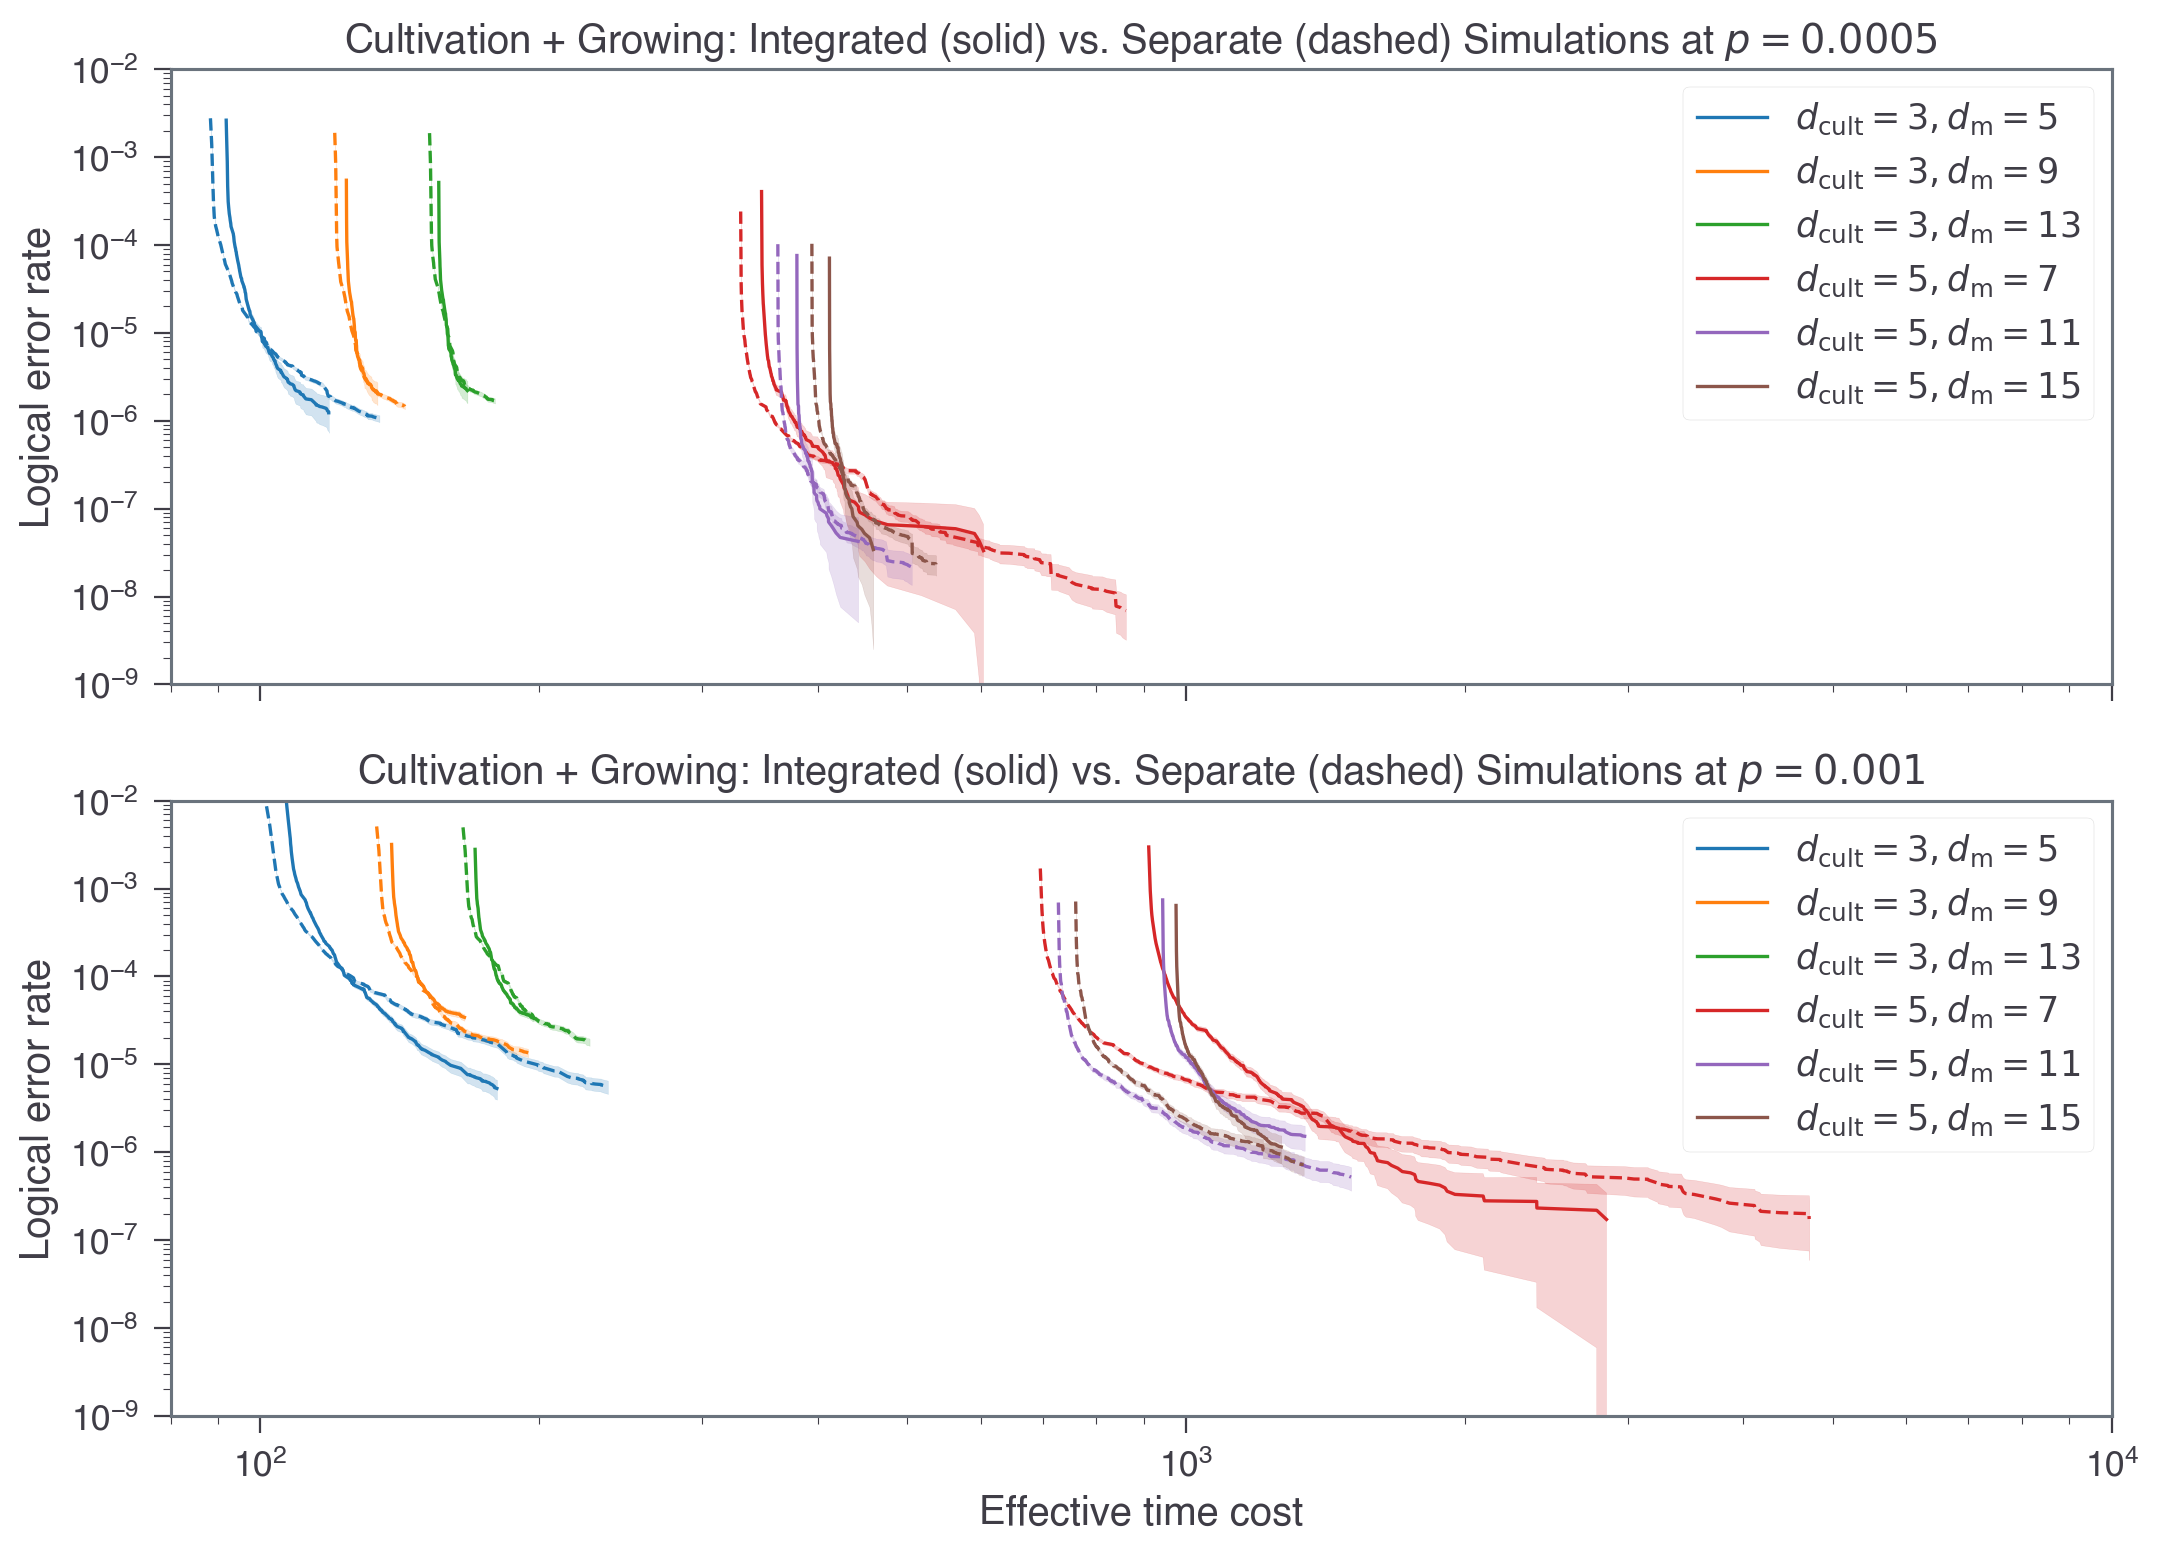

In [ ]:
fig, axes = plt.subplots(ncols=1, nrows=2, figsize=(DFT_FIG_WIDTH_WIDE, 8), sharex=True)

col_to_draw = "time_cost"

for i_row in range(2):
    p = [5e-4, 1e-3][i_row]
    ax: plt.Axes = axes[i_row]

    for i_dcult, dcult in enumerate([3, 5]):
        dmlist = [dm for p_, dcult_, dm in dfs.keys() if p_ == p and dcult_ == dcult]
        for i_dm, dm in enumerate(dmlist):
            df = dfs[(p, dcult, dm)]
            df_org = dfs_org[(p, dcult, dm)]

            df = filter_df(df)
            df_org = filter_df(df_org)
            color = COLORS(
                i_dm + 3 * i_dcult
            )  # Use different color ranges for dcult=3 and dcult=5

            ax.plot(
                df[col_to_draw],
                df["plog"],
                color=color,
                label=rf"$d_\mathrm{{cult}}={dcult}, d_\mathrm{{m}}={dm}$",
            )
            ax.fill_between(
                df[col_to_draw],
                df["plog"] - df["delta_plog"],
                df["plog"] + df["delta_plog"],
                color=color,
                alpha=0.2,
            )
            ax.plot(
                df_org[col_to_draw],
                df_org["plog"],
                color=color,
                linestyle="--",
            )
            ax.fill_between(
                df_org[col_to_draw],
                df_org["plog"] - df_org["delta_plog"],
                df_org["plog"] + df_org["delta_plog"],
                color=color,
                alpha=0.2,
            )

    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.legend()
    ax.set_title(
        rf"Cultivation + Growing: Integrated (solid) vs. Separate (dashed) Simulations at $p={p}$"
    )
    if i_row == 1:
        ax.set_xlabel("Effective time cost")
    ax.set_ylabel("Logical error rate")

    ax.set_xlim(80, 1e4)
    ax.set_ylim(1e-9, 1e-2)

fig.tight_layout()
fig.savefig("figs/integrated_cult_growing_time_cost.pdf", bbox_inches="tight")

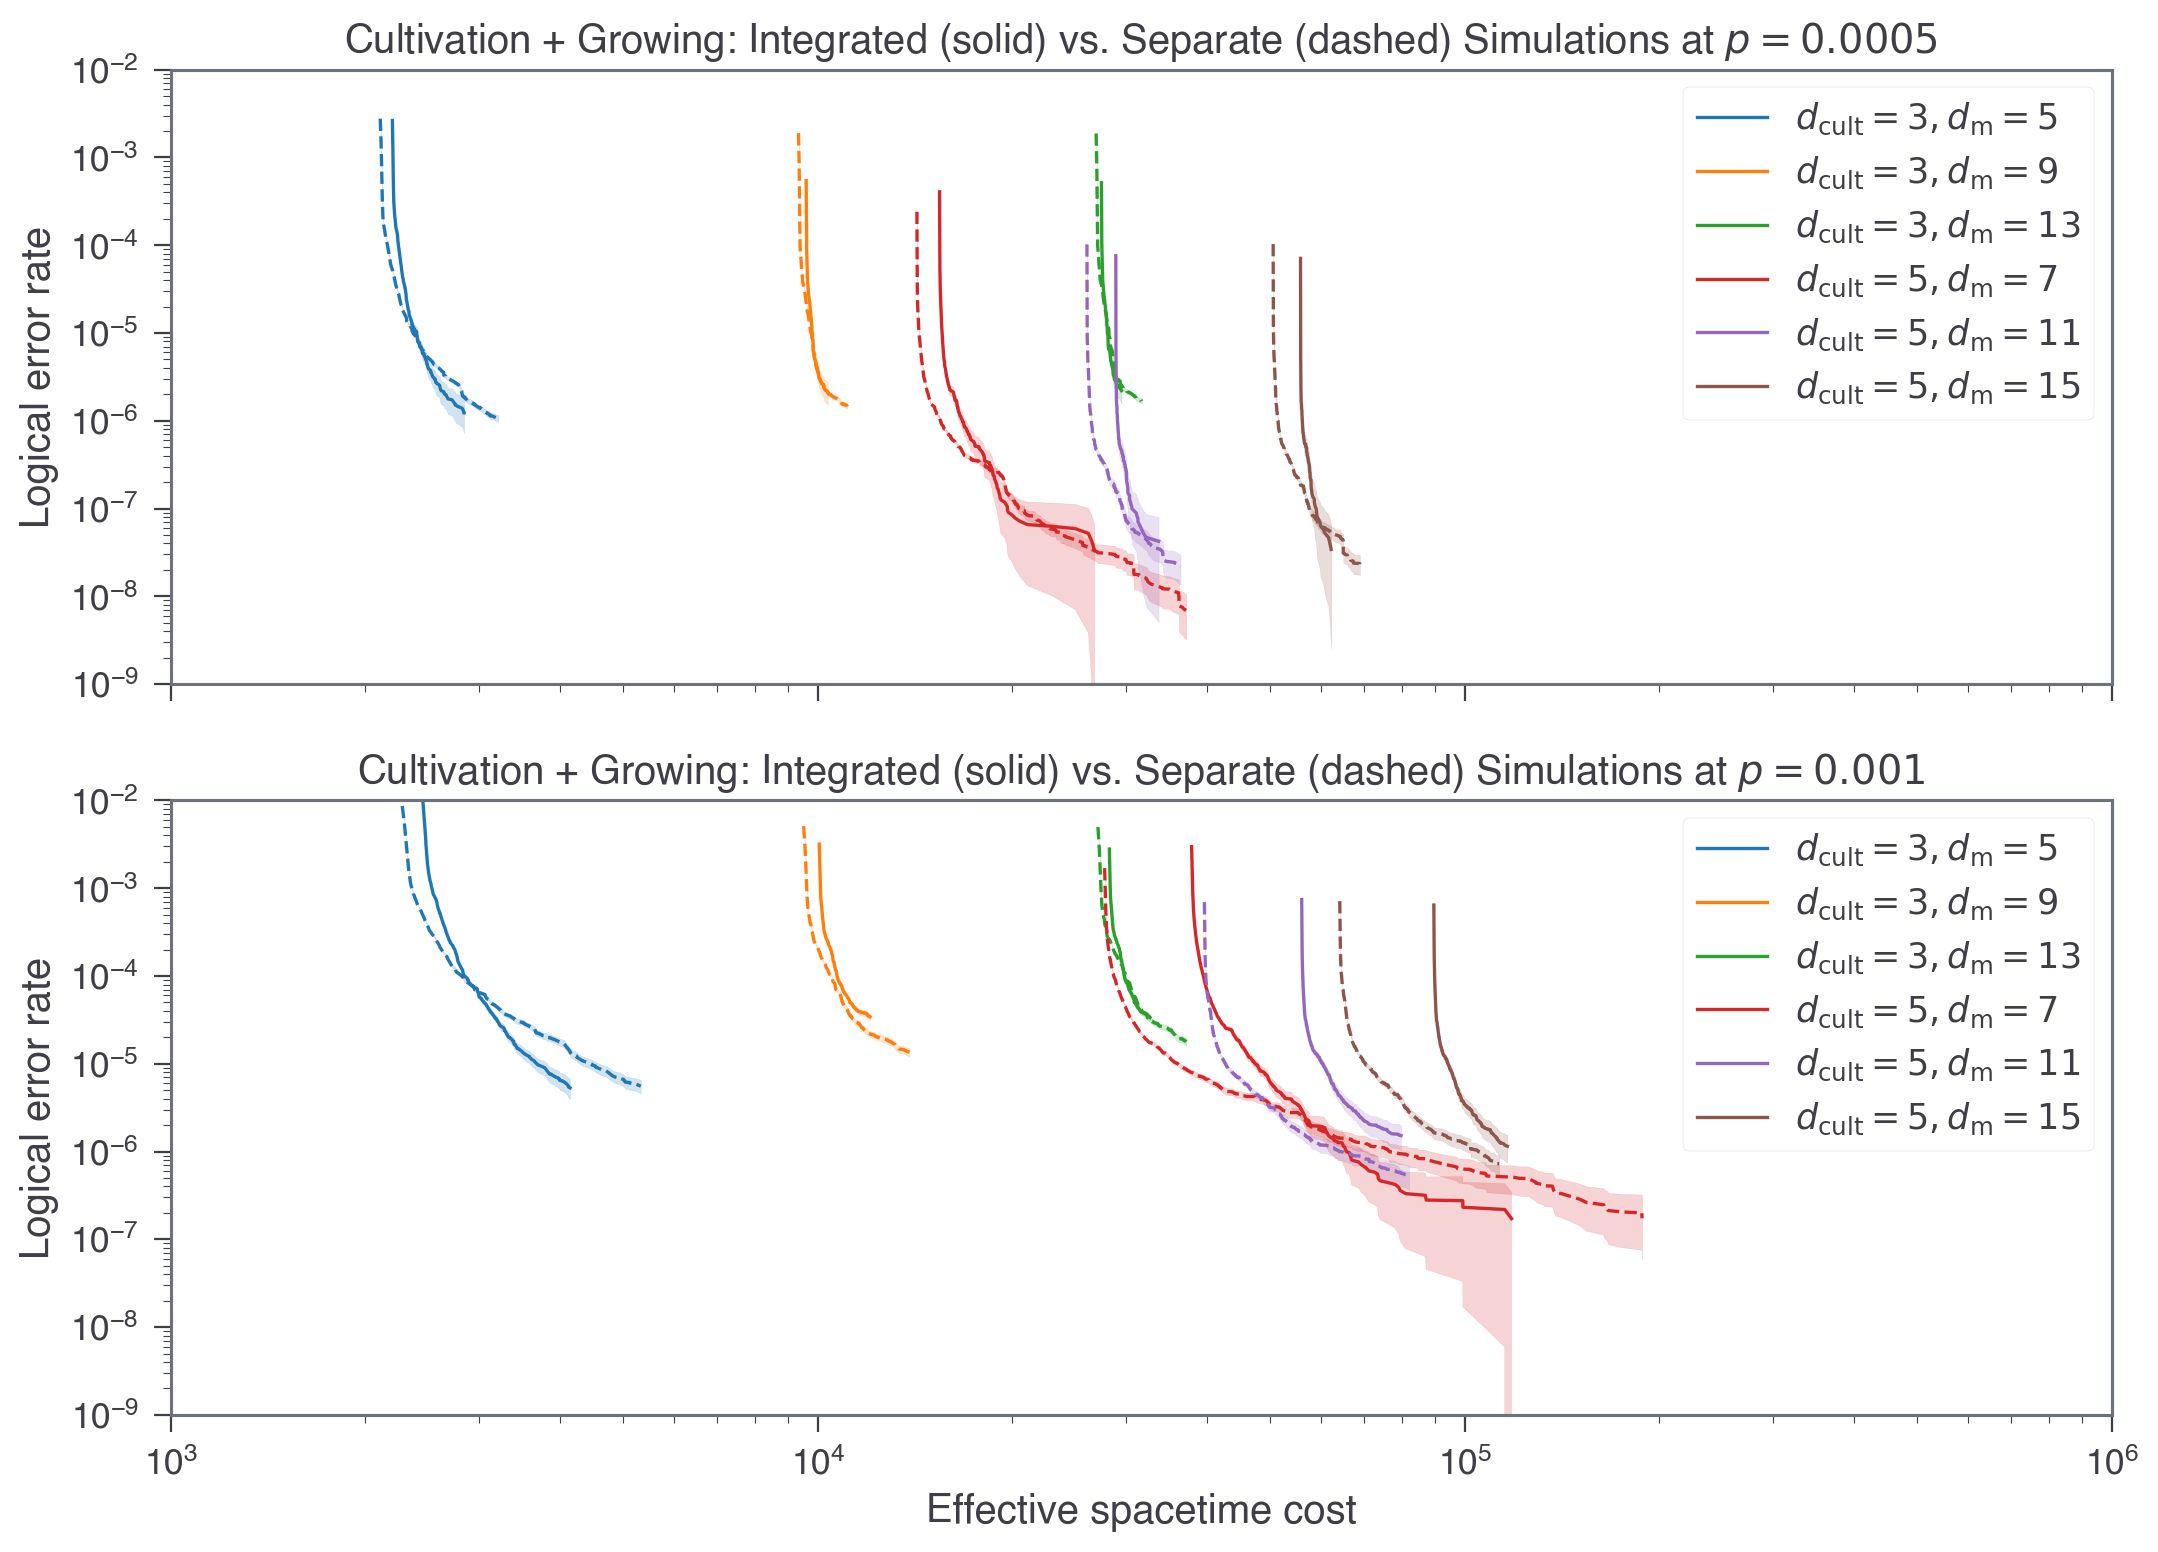

In [59]:
fig, axes = plt.subplots(ncols=1, nrows=2, figsize=(DFT_FIG_WIDTH_WIDE, 8), sharex=True)

col_to_draw = "spacetime_cost"

for i_row in range(2):
    p = [5e-4, 1e-3][i_row]
    ax = axes[i_row]

    for i_dcult, dcult in enumerate([3, 5]):
        dmlist = [dm for p_, dcult_, dm in dfs.keys() if p_ == p and dcult_ == dcult]
        for i_dm, dm in enumerate(dmlist):
            df = dfs[(p, dcult, dm)]
            df_org = dfs_org[(p, dcult, dm)]

            df = filter_df(df)
            df_org = filter_df(df_org)
            color = COLORS(
                i_dm + 3 * i_dcult
            )  # Use different color ranges for dcult=3 and dcult=5

            ax.plot(
                df[col_to_draw],
                df["plog"],
                color=color,
                label=rf"$d_\mathrm{{cult}}={dcult}, d_\mathrm{{m}}={dm}$",
            )
            ax.fill_between(
                df[col_to_draw],
                df["plog"] - df["delta_plog"],
                df["plog"] + df["delta_plog"],
                color=color,
                alpha=0.2,
            )
            ax.plot(
                df_org[col_to_draw],
                df_org["plog"],
                color=color,
                linestyle="--",
            )
            ax.fill_between(
                df_org[col_to_draw],
                df_org["plog"] - df_org["delta_plog"],
                df_org["plog"] + df_org["delta_plog"],
                color=color,
                alpha=0.2,
            )

    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.legend()
    ax.set_title(
        rf"Cultivation + Growing: Integrated (solid) vs. Separate (dashed) Simulations at $p={p}$"
    )
    if i_row == 1:
        ax.set_xlabel("Effective spacetime cost")
    ax.set_ylabel("Logical error rate")

    ax.set_xlim(1e3, 1e6)
    ax.set_ylim(1e-9, 1e-2)

fig.tight_layout()
fig.savefig("figs/integrated_cult_growing_spacetime_cost.pdf", bbox_inches="tight")

3.420072383362569e-08
0.3467865690165553
2.319934921946043e-08
0.35


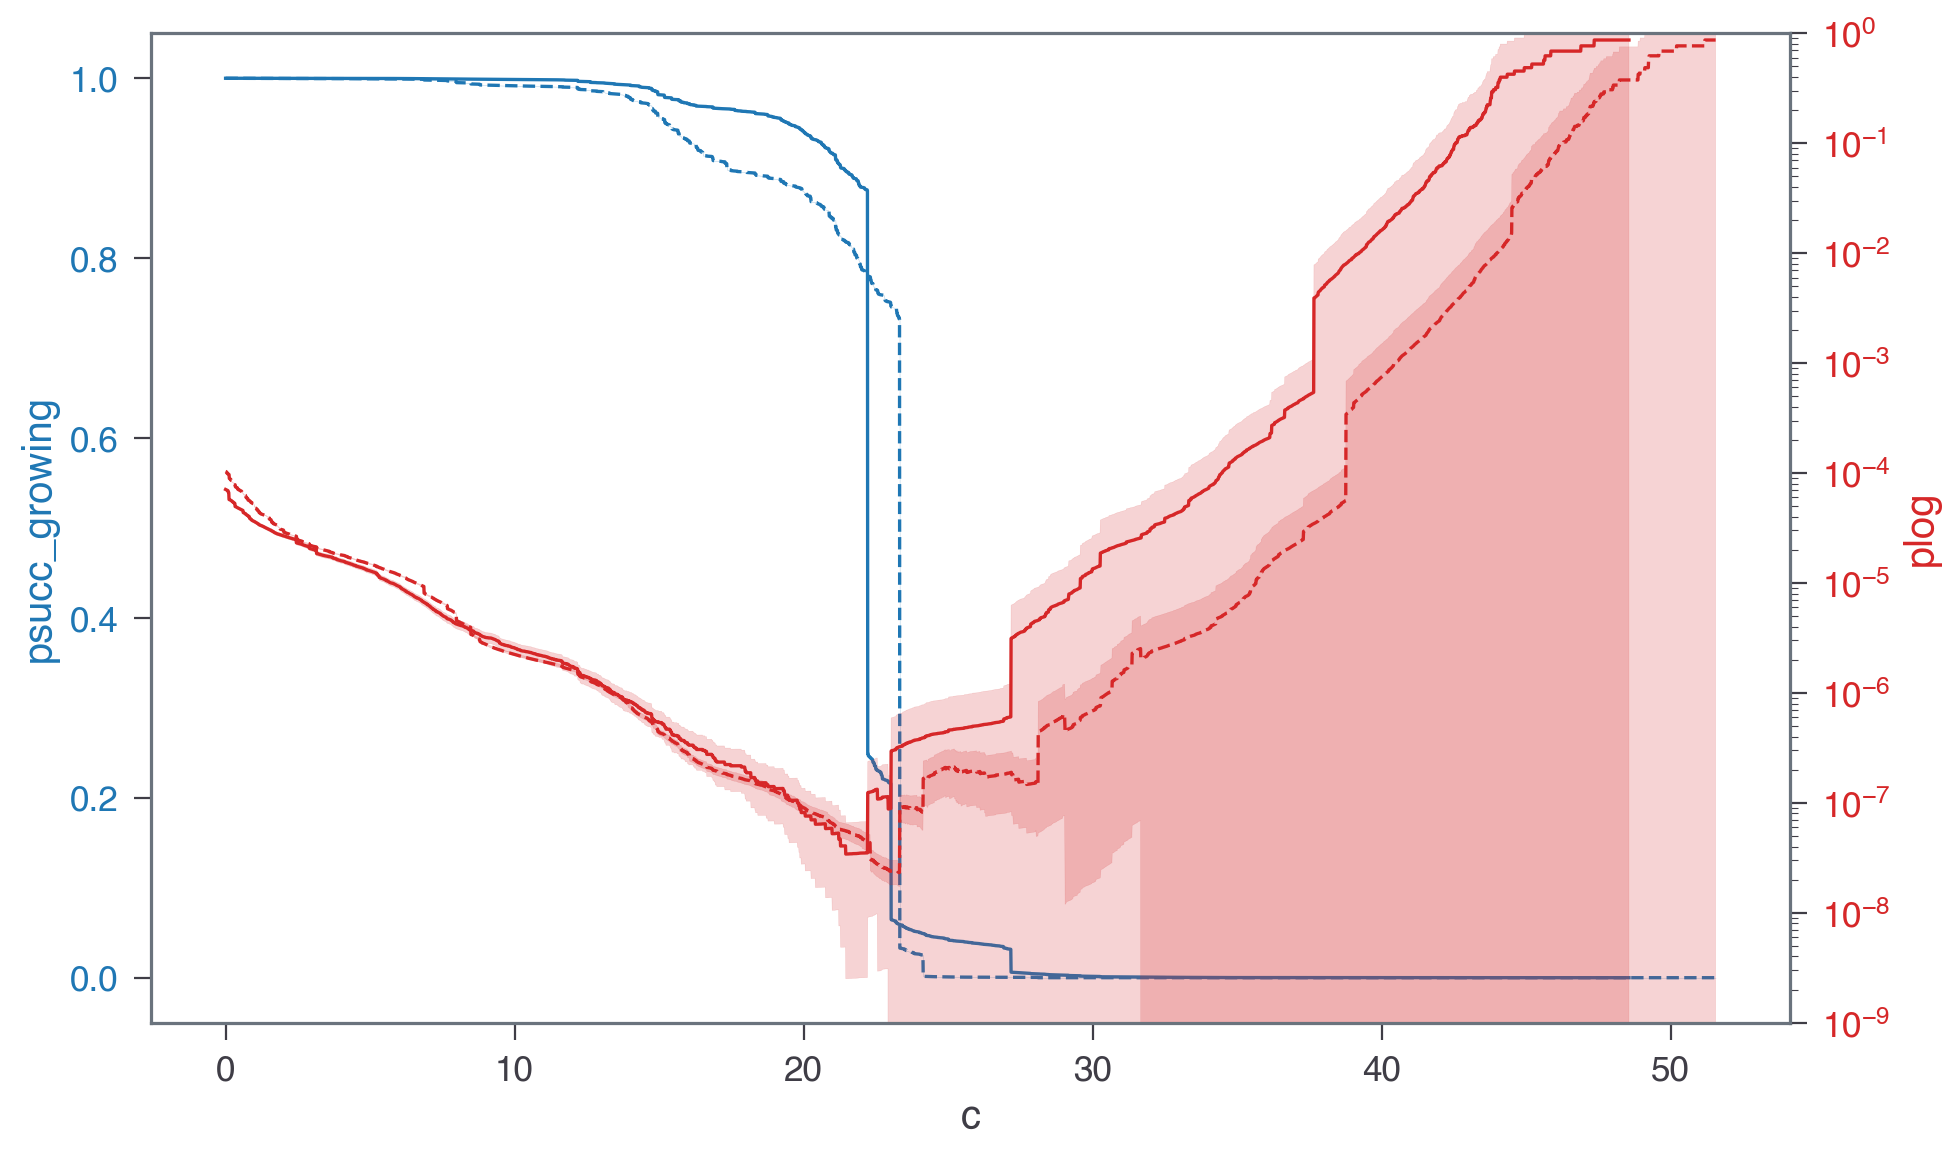

In [60]:
fig, ax1 = plt.subplots(figsize=(10, 6))

ax2 = ax1.twinx()

for i in range(2):
    dfs_now = [dfs, dfs_org][i]
    df = dfs_now[(5e-4, 5, 15)].reset_index()
    print(min(df["plog"]))
    print(min(df["psucc_cult"]))

    linestyle = ["-", "--"][i]

    # Left axis for psucc_growing
    color = "tab:blue"
    sns.lineplot(df, x="c", y="psucc_growing", ax=ax1, color=color, linestyle=linestyle)
    ax1.fill_between(
        df["c"],
        df["psucc_growing"] - df["delta_psucc_growing"],
        df["psucc_growing"] + df["delta_psucc_growing"],
        color=color,
        alpha=0.2,
    )

    # Right axis for plog with log scale
    color = "tab:red"
    sns.lineplot(df, x="c", y="plog", ax=ax2, color=color, linestyle=linestyle)
    ax2.fill_between(
        df["c"],
        df["plog"] - df["delta_plog"],
        df["plog"] + df["delta_plog"],
        color=color,
        alpha=0.2,
    )

ax1.set_xlabel("c")
ax1.set_ylabel("psucc_growing", color="tab:blue")
ax1.tick_params(axis="y", labelcolor="tab:blue")

ax2.set_yscale("log")
ax2.set_ylabel("plog", color="tab:red")
ax2.tick_params(axis="y", labelcolor="tab:red")

ax2.set_ylim(1e-9, 1)

fig.tight_layout()
plt.show()